In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os

In [2]:
dt = 0.01
TR = 1
down_sample = int(TR / dt)
sigma = 1

In [3]:
def h(x):
    return np.tanh(x)

def NextTR(W, X_init, noise):
    X_res = X_init.copy()
    for i in range(down_sample):
        X_res = X_res + (-X_res + np.dot(W.T, h(X_res))) * dt + noise[i]
    return X_res

def RNN_heterogeneous_SNR(W, X_init, length, SNR_per_region, pert_strength=1.0, pert_step=200):
    """RNN with region-specific SNR levels"""
    np.random.seed(0)
    n = len(X_init)
    X = [X_init]
    real_EC = np.zeros((n, n))
    pert_count = 0
    noise_scales = 1.0 / SNR_per_region

    for i in range(1, length):
        noise = np.zeros((down_sample, n))
        for j in range(n):
            noise[:, j] = (noise_scales[j] * sigma * np.sqrt(dt)) * np.random.normal(0, 1, down_sample)

        X.append(NextTR(W, X[-1], noise))

        if i % pert_step == 0:
            pert_count += 1
            for j in range(n):
                perted_init = X[-2].copy()
                perted_init[j] += pert_strength
                real_EC[j] += NextTR(W, perted_init, noise) - X[-1]

    real_EC /= pert_count
    np.fill_diagonal(real_EC, 0)
    return np.array(X), real_EC

In [4]:
def apply_spatial_smoothing(signal, merge_groups):
    """Merge regions based on spatial smoothing"""
    n_timesteps = signal.shape[0]
    n_merged = len(merge_groups)
    smoothed_signal = np.zeros((n_timesteps, n_merged))
    for i, group in enumerate(merge_groups):
        smoothed_signal[:, i] = np.mean(signal[:, group], axis=1)
    return smoothed_signal, merge_groups

def create_merge_groups(n_regions, merge_pairs):
    """Create merge groups from pairs"""
    merged = set()
    groups = []
    for pair in merge_pairs:
        merged.update(pair)
    for i in range(n_regions):
        if i in merged:
            for pair in merge_pairs:
                if i in pair and list(pair) not in groups:
                    groups.append(list(pair))
        else:
            groups.append([i])
    return sorted(groups, key=lambda x: x[0])

In [5]:
def flat_without_diagonal(matrix):
    n = matrix.shape[0]
    flattened = []
    for i in range(n):
        for j in list(range(i)) + list(range(i + 1, n)):
            flattened.append(matrix[i][j])
    return np.array(flattened)

In [6]:
# THALAMO-CORTICAL NETWORK CONFIGURATION

# Network structure
N_THALAMUS = 15     # voxel-level thalamic nodes
N_CORTEX = 35       # ROI-level cortical nodes
N_TOTAL = N_THALAMUS + N_CORTEX  # 50 total

# SNR ranges
THAL_SNR_RANGE = (3, 8)      # low SNR
CORT_SNR_RANGE = (15, 30)    # high SNR

# Spatial smoothing: merge adjacent thalamic voxels into ROIs
# Thalamus: 15 voxels → ~8 ROIs (pairs + 1 singleton)
THAL_MERGE_PAIRS = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11), (12, 13)]
# This merges 14 voxels into 7 pairs + leaves voxel 14 alone → 8 thalamic ROIs
# Cortex: already at ROI level, no merging → 35 cortical ROIs
# Total coarse: 8 + 35 = 43 ROIs

DATA_LENGTH = 8000
RANDOM_SEED = 42

print(f"Network: {N_THALAMUS} thalamic voxels + {N_CORTEX} cortical ROIs = {N_TOTAL} total")
print(f"Thalamus SNR: {THAL_SNR_RANGE[0]}-{THAL_SNR_RANGE[1]}")
print(f"Cortex SNR: {CORT_SNR_RANGE[0]}-{CORT_SNR_RANGE[1]}")
print(f"After smoothing: {N_THALAMUS - len(THAL_MERGE_PAIRS)} thalamic ROIs + {N_CORTEX} cortical ROIs")

Network: 15 thalamic voxels + 35 cortical ROIs = 50 total
Thalamus SNR: 3-8
Cortex SNR: 15-30
After smoothing: 8 thalamic ROIs + 35 cortical ROIs


In [7]:
def generate_thalamocortical_SC(n_thal, n_cort, random_seed=42):
    """
    Generate structured SC with biologically motivated block structure.

    Thalamo-cortical connections are stronger (relay function),
    cortico-thalamic are moderate (feedback), within-region are standard.
    """
    np.random.seed(random_seed)
    n_total = n_thal + n_cort
    SC = np.zeros((n_total, n_total))

    # Within-thalamus: moderate, sparser
    SC[:n_thal, :n_thal] = np.random.normal(0, 0.8 / np.sqrt(n_thal), (n_thal, n_thal))

    # Within-cortex: moderate
    SC[n_thal:, n_thal:] = np.random.normal(0, 1.0 / np.sqrt(n_cort), (n_cort, n_cort))

    # Thalamus -> Cortex (relay): stronger
    SC[:n_thal, n_thal:] = np.random.normal(0, 1.5 / np.sqrt(n_total), (n_thal, n_cort))

    # Cortex -> Thalamus (feedback): moderate
    SC[n_thal:, :n_thal] = np.random.normal(0, 1.0 / np.sqrt(n_total), (n_cort, n_thal))

    np.fill_diagonal(SC, 0)
    return SC

def generate_thalamocortical_SNR(n_thal, n_cort, thal_range, cort_range, random_seed=42):
    """Generate region-specific SNR: low for thalamus, high for cortex"""
    np.random.seed(random_seed + 100)
    snr = np.zeros(n_thal + n_cort)
    snr[:n_thal] = np.random.uniform(thal_range[0], thal_range[1], n_thal)
    snr[n_thal:] = np.random.uniform(cort_range[0], cort_range[1], n_cort)
    return snr

def create_thalamocortical_merge_groups(n_thal, n_cort, thal_merge_pairs):
    """
    Create merge groups:
    - Thalamic voxels: merge according to thal_merge_pairs
    - Cortical ROIs: each stays as singleton (already parcellated)
    """
    # Thalamic merge groups
    thal_merged = set()
    thal_groups = []
    for pair in thal_merge_pairs:
        thal_merged.update(pair)
    for i in range(n_thal):
        if i in thal_merged:
            for pair in thal_merge_pairs:
                if i in pair and list(pair) not in thal_groups:
                    thal_groups.append(list(pair))
        else:
            thal_groups.append([i])
    thal_groups = sorted(thal_groups, key=lambda x: x[0])

    # Cortical groups: each ROI is its own group (no merging)
    cort_groups = [[n_thal + i] for i in range(n_cort)]

    all_groups = thal_groups + cort_groups
    return all_groups, len(thal_groups), n_cort

In [8]:
def generate_thalamocortical_data(n_thal=15, n_cort=35, data_length=8000,
                                  random_seed=42, snr_mode='realistic',
                                  spatial_mode='thalamic_smooth',
                                  thal_snr_range=(3, 8), cort_snr_range=(15, 30),
                                  thal_merge_pairs=None):
    """
    Generate thalamo-cortical RNN simulation data.

    Parameters:
    -----------
    snr_mode: 'uniform' | 'realistic' | 'severe'
        uniform: same SNR for all regions
        realistic: low thalamic SNR, high cortical SNR
        severe: very low thalamic SNR
    spatial_mode: 'original' | 'thalamic_smooth'
        original: no smoothing
        thalamic_smooth: merge adjacent thalamic voxels
    """
    n_total = n_thal + n_cort

    SC = generate_thalamocortical_SC(n_thal, n_cort, random_seed)

    np.random.seed(random_seed + 200)
    init = np.random.normal(0, 1, n_total)

    if snr_mode == 'uniform':
        SNR = np.ones(n_total) * 15.0
    elif snr_mode == 'realistic':
        SNR = generate_thalamocortical_SNR(n_thal, n_cort, thal_snr_range, cort_snr_range, random_seed)
    elif snr_mode == 'severe':
        SNR = generate_thalamocortical_SNR(n_thal, n_cort, (2, 5), cort_snr_range, random_seed)

    signal, real_EC = RNN_heterogeneous_SNR(SC, init, data_length, SNR)

    result = {
        'signal': signal,
        'SC': SC,
        'real_EC': real_EC,
        'SNR': SNR,
        'n_thal': n_thal,
        'n_cort': n_cort,
        'n_total': n_total,
    }

    if spatial_mode == 'thalamic_smooth':
        if thal_merge_pairs is None:
            thal_merge_pairs = THAL_MERGE_PAIRS

        merge_groups, n_thal_merged, n_cort_kept = create_thalamocortical_merge_groups(
            n_thal, n_cort, thal_merge_pairs
        )
        smoothed_signal, _ = apply_spatial_smoothing(signal, merge_groups)

        result['smoothed_signal'] = smoothed_signal
        result['merge_groups'] = merge_groups
        result['n_thal_merged'] = n_thal_merged
        result['n_cort_merged'] = n_cort_kept
        result['n_merged_total'] = n_thal_merged + n_cort_kept

    return result

In [9]:
def export_thalamocortical_data(data_dict, prefix, output_dir='./sim_data_thalcort'):

    os.makedirs(output_dir, exist_ok=True)

    np.savetxt(f'{output_dir}/{prefix}_signal.txt', data_dict['signal'])
    np.savetxt(f'{output_dir}/{prefix}_SC.txt', data_dict['SC'])
    np.savetxt(f'{output_dir}/{prefix}_real_EC.txt', data_dict['real_EC'])
    np.savetxt(f'{output_dir}/{prefix}_SNR.txt', data_dict['SNR'])

    with open(f'{output_dir}/{prefix}_structure.txt', 'w') as f:
        f.write(f"n_thal={data_dict['n_thal']}\n")
        f.write(f"n_cort={data_dict['n_cort']}\n")
        f.write(f"n_total={data_dict['n_total']}\n")

    if 'smoothed_signal' in data_dict:
        np.savetxt(f'{output_dir}/{prefix}_smoothed_signal.txt', data_dict['smoothed_signal'])
        with open(f'{output_dir}/{prefix}_merge_groups.txt', 'w') as f:
            for group in data_dict['merge_groups']:
                f.write(','.join(map(str, group)) + '\n')
        with open(f'{output_dir}/{prefix}_structure.txt', 'a') as f:
            f.write(f"n_thal_merged={data_dict['n_thal_merged']}\n")
            f.write(f"n_cort_merged={data_dict['n_cort_merged']}\n")
            f.write(f"n_merged_total={data_dict['n_merged_total']}\n")

In [10]:
scenarios = {
    'thalcort_baseline': {
        'snr_mode': 'uniform',
        'spatial_mode': 'original',
        'desc': 'Clean reference: uniform SNR, no smoothing'
    },
    'thalcort_snr_only': {
        'snr_mode': 'realistic',
        'spatial_mode': 'original',
        'desc': 'SNR mismatch only: low thal, high cort, no smoothing'
    },
    'thalcort_smooth_only': {
        'snr_mode': 'uniform',
        'spatial_mode': 'thalamic_smooth',
        'desc': 'Smoothing only: uniform SNR, thalamic voxels merged'
    },
    'thalcort_realistic': {
        'snr_mode': 'realistic',
        'spatial_mode': 'thalamic_smooth',
        'desc': 'REALISTIC: low thal SNR + thalamic smoothing'
    },
    'thalcort_severe': {
        'snr_mode': 'severe',
        'spatial_mode': 'thalamic_smooth',
        'desc': 'SEVERE: very low thal SNR (2-5) + thalamic smoothing'
    },
}

all_data = {}
for name, config in scenarios.items():
    print(f"\nGenerating {name}: {config['desc']}")
    data = generate_thalamocortical_data(
        n_thal=N_THALAMUS, n_cort=N_CORTEX, data_length=DATA_LENGTH,
        random_seed=RANDOM_SEED, snr_mode=config['snr_mode'],
        spatial_mode=config['spatial_mode']
    )
    all_data[name] = data
    export_thalamocortical_data(data, name)


Generating thalcort_baseline: Clean reference: uniform SNR, no smoothing

Generating thalcort_snr_only: SNR mismatch only: low thal, high cort, no smoothing

Generating thalcort_smooth_only: Smoothing only: uniform SNR, thalamic voxels merged

Generating thalcort_realistic: REALISTIC: low thal SNR + thalamic smoothing

Generating thalcort_severe: SEVERE: very low thal SNR (2-5) + thalamic smoothing


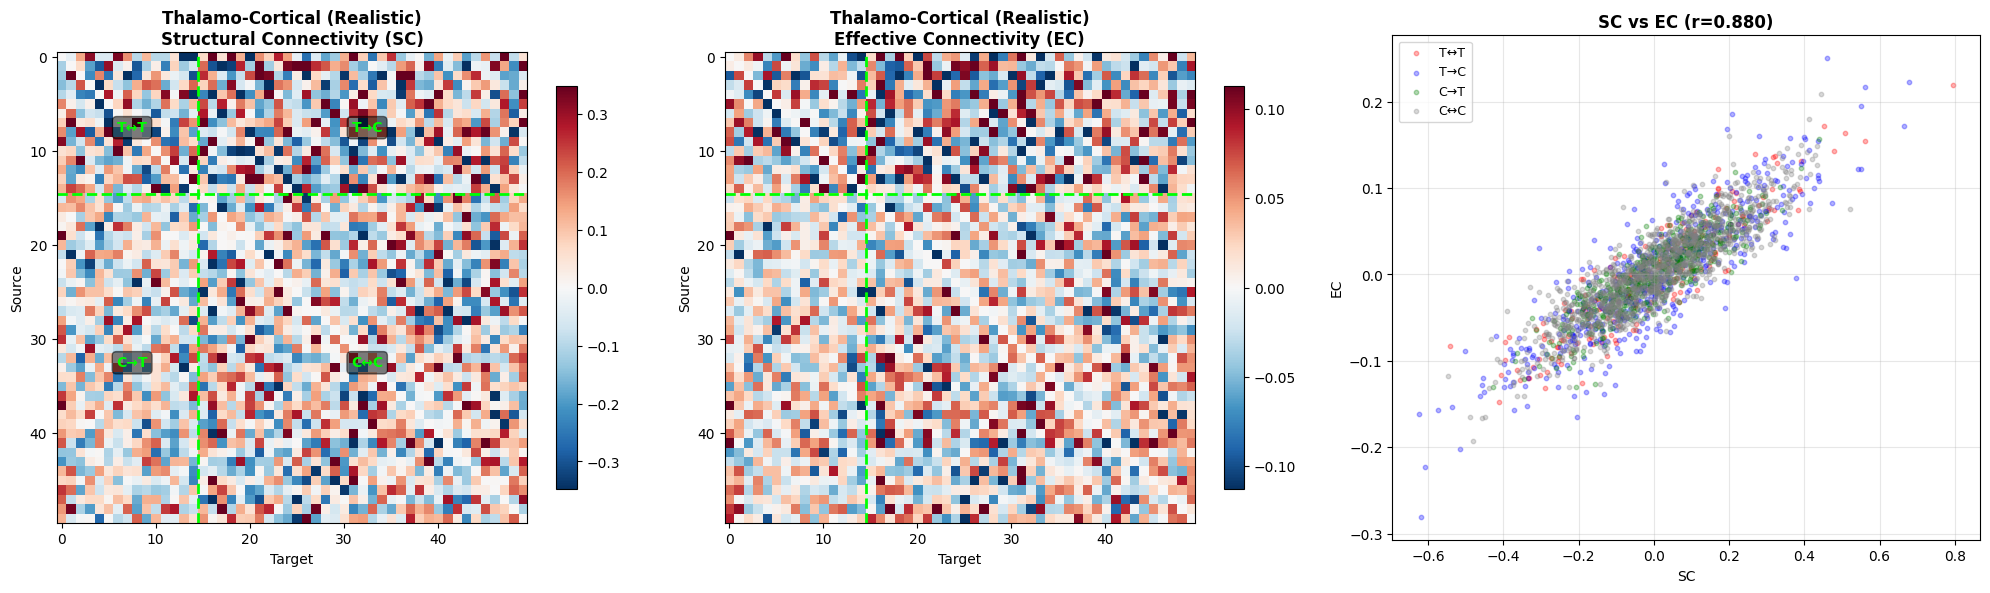

In [11]:
def visualize_thalamocortical(data, scenario_name, n_thal=N_THALAMUS):
    """Visualize SC, EC with block structure annotations"""
    SC = data['SC']
    EC = data['real_EC']
    n = SC.shape[0]

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # SC heatmap
    im0 = axes[0].imshow(SC, cmap='RdBu_r', vmin=-np.percentile(np.abs(SC), 95),
                          vmax=np.percentile(np.abs(SC), 95), aspect='equal')
    axes[0].axhline(y=n_thal - 0.5, color='lime', linewidth=2, linestyle='--')
    axes[0].axvline(x=n_thal - 0.5, color='lime', linewidth=2, linestyle='--')
    axes[0].set_title(f'{scenario_name}\nStructural Connectivity (SC)', fontweight='bold')
    axes[0].set_xlabel('Target'); axes[0].set_ylabel('Source')
    axes[0].text(n_thal/2, n_thal/2, 'T↔T', ha='center', va='center', fontsize=10,
                 color='lime', fontweight='bold', bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    axes[0].text(n_thal + (n-n_thal)/2, n_thal/2, 'T→C', ha='center', va='center', fontsize=10,
                 color='lime', fontweight='bold', bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    axes[0].text(n_thal/2, n_thal + (n-n_thal)/2, 'C→T', ha='center', va='center', fontsize=10,
                 color='lime', fontweight='bold', bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    axes[0].text(n_thal + (n-n_thal)/2, n_thal + (n-n_thal)/2, 'C↔C', ha='center', va='center',
                 fontsize=10, color='lime', fontweight='bold', bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    plt.colorbar(im0, ax=axes[0], shrink=0.8)

    # EC heatmap
    im1 = axes[1].imshow(EC, cmap='RdBu_r', vmin=-np.percentile(np.abs(EC), 95),
                          vmax=np.percentile(np.abs(EC), 95), aspect='equal')
    axes[1].axhline(y=n_thal - 0.5, color='lime', linewidth=2, linestyle='--')
    axes[1].axvline(x=n_thal - 0.5, color='lime', linewidth=2, linestyle='--')
    axes[1].set_title(f'{scenario_name}\nEffective Connectivity (EC)', fontweight='bold')
    axes[1].set_xlabel('Target'); axes[1].set_ylabel('Source')
    plt.colorbar(im1, ax=axes[1], shrink=0.8)

    sc_flat = flat_without_diagonal(SC)
    ec_flat = flat_without_diagonal(EC)

    colors = []
    labels = []
    for i in range(n):
        for j in list(range(i)) + list(range(i + 1, n)):
            if i < n_thal and j < n_thal:
                colors.append('red'); labels.append('T↔T')
            elif i < n_thal and j >= n_thal:
                colors.append('blue'); labels.append('T→C')
            elif i >= n_thal and j < n_thal:
                colors.append('green'); labels.append('C→T')
            else:
                colors.append('gray'); labels.append('C↔C')

    for block_color, block_label in [('red', 'T↔T'), ('blue', 'T→C'), ('green', 'C→T'), ('gray', 'C↔C')]:
        mask = [c == block_color for c in colors]
        axes[2].scatter(np.array(sc_flat)[mask], np.array(ec_flat)[mask],
                       c=block_color, alpha=0.3, s=10, label=block_label)

    r_all, _ = pearsonr(sc_flat, ec_flat)
    axes[2].set_title(f'SC vs EC (r={r_all:.3f})', fontweight='bold')
    axes[2].set_xlabel('SC'); axes[2].set_ylabel('EC')
    axes[2].legend(loc='upper left', fontsize=9)
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

visualize_thalamocortical(all_data['thalcort_realistic'], 'Thalamo-Cortical (Realistic)')

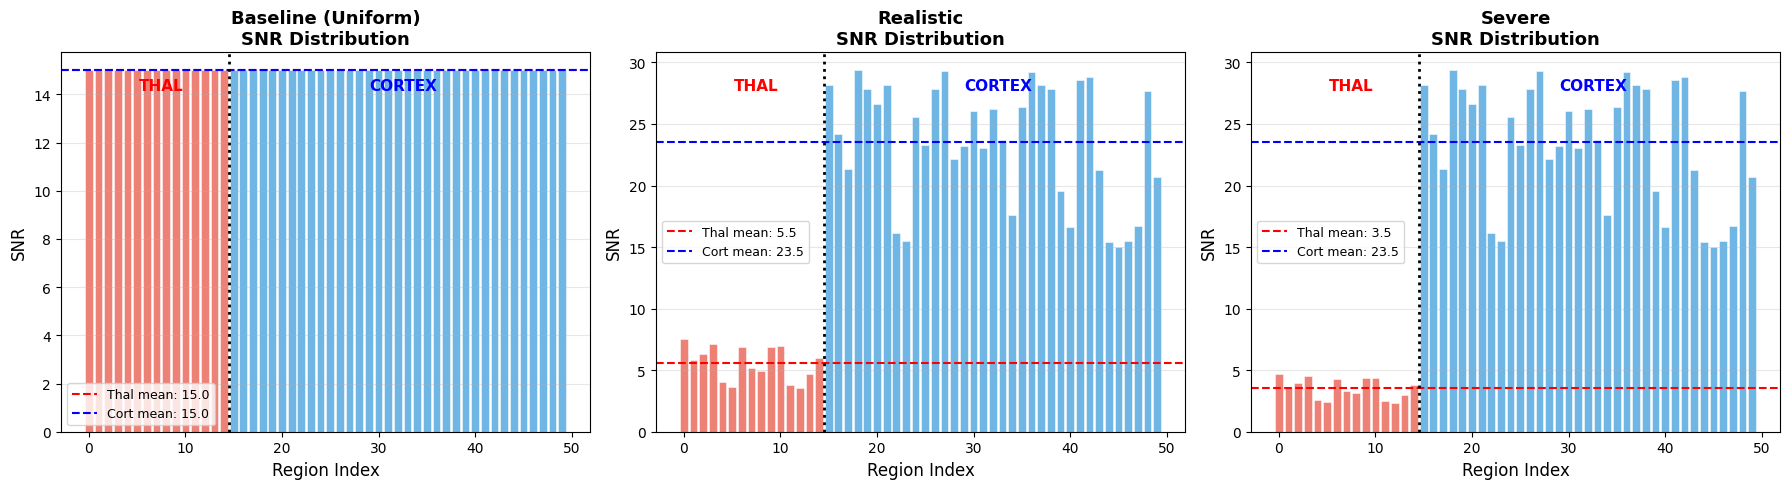

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

snr_scenarios = ['thalcort_baseline', 'thalcort_realistic', 'thalcort_severe']
titles = ['Baseline (Uniform)', 'Realistic', 'Severe']

for idx, (name, title) in enumerate(zip(snr_scenarios, titles)):
    snr = all_data[name]['SNR']
    colors = ['#E74C3C'] * N_THALAMUS + ['#3498DB'] * N_CORTEX

    axes[idx].bar(range(len(snr)), snr, color=colors, alpha=0.7, edgecolor='white', linewidth=0.5)
    axes[idx].axhline(y=snr[:N_THALAMUS].mean(), color='red', linestyle='--', linewidth=1.5,
                      label=f'Thal mean: {snr[:N_THALAMUS].mean():.1f}')
    axes[idx].axhline(y=snr[N_THALAMUS:].mean(), color='blue', linestyle='--', linewidth=1.5,
                      label=f'Cort mean: {snr[N_THALAMUS:].mean():.1f}')
    axes[idx].axvline(x=N_THALAMUS - 0.5, color='black', linestyle=':', linewidth=2)
    axes[idx].set_xlabel('Region Index', fontsize=12)
    axes[idx].set_ylabel('SNR', fontsize=12)
    axes[idx].set_title(f'{title}\nSNR Distribution', fontsize=13, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].text(N_THALAMUS/2, axes[idx].get_ylim()[1]*0.9, 'THAL',
                   ha='center', fontsize=11, fontweight='bold', color='red')
    axes[idx].text(N_THALAMUS + N_CORTEX/2, axes[idx].get_ylim()[1]*0.9, 'CORTEX',
                   ha='center', fontsize=11, fontweight='bold', color='blue')

plt.tight_layout()
plt.show()

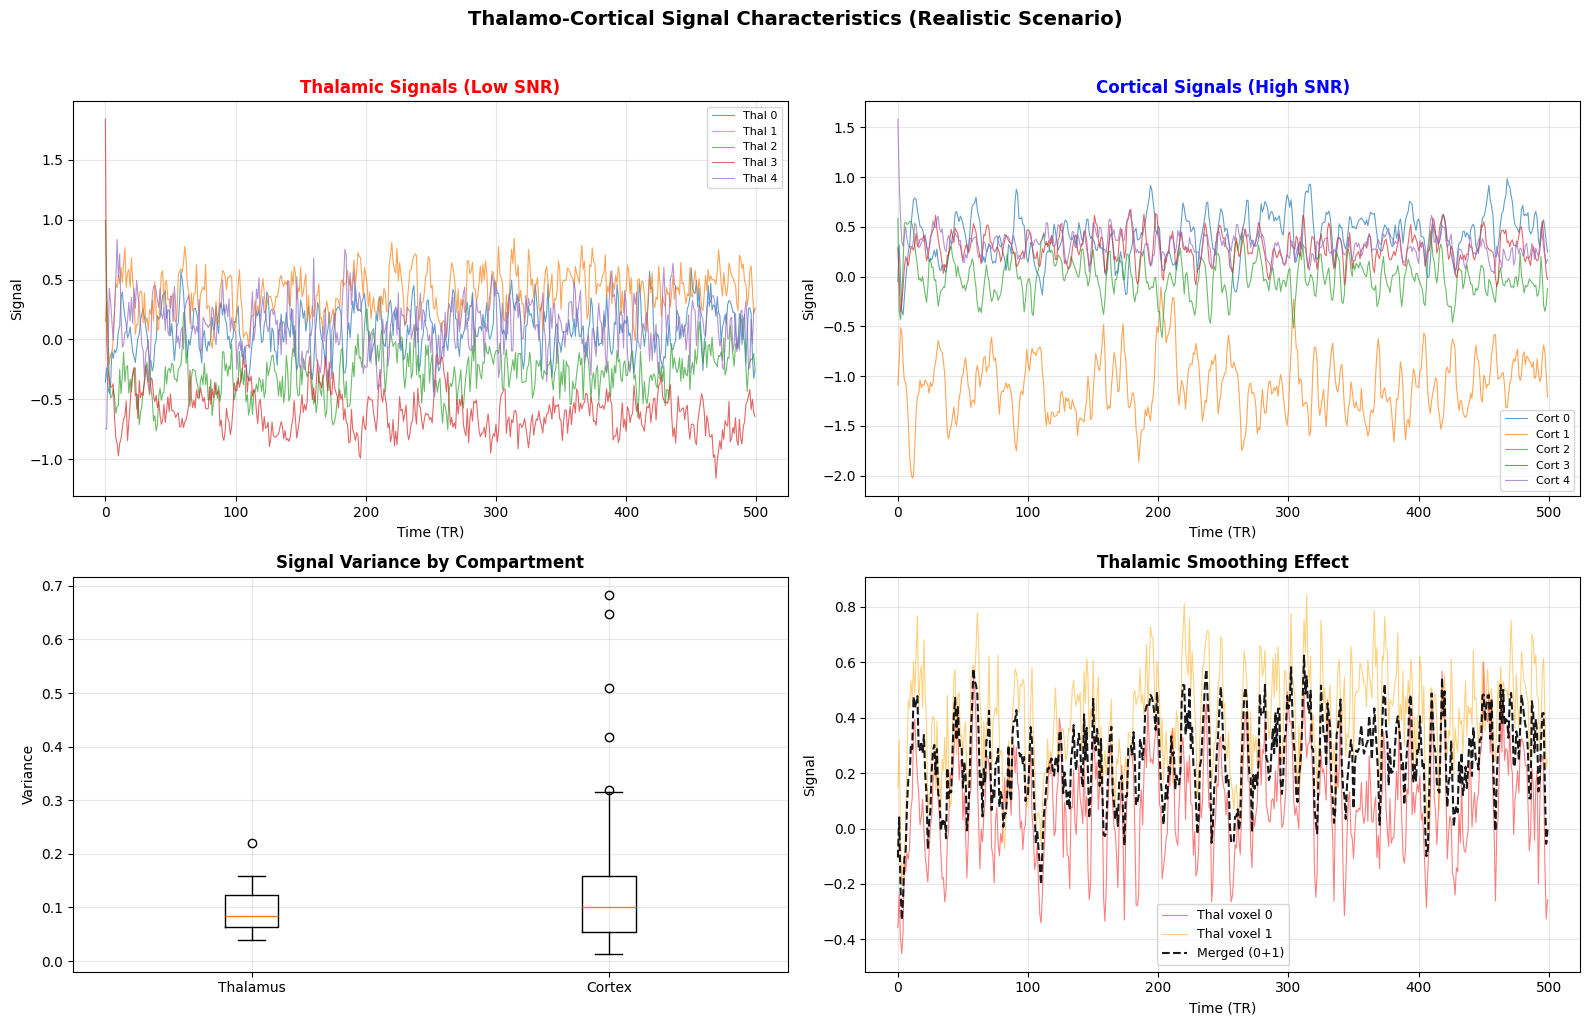

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

data = all_data['thalcort_realistic']
signal = data['signal']
t_range = slice(0, 500)  # first 500 TRs

# Thalamic signals (noisy)
for i in range(min(5, N_THALAMUS)):
    axes[0, 0].plot(signal[t_range, i], alpha=0.7, linewidth=0.8, label=f'Thal {i}')
axes[0, 0].set_title('Thalamic Signals (Low SNR)', fontweight='bold', color='red')
axes[0, 0].set_xlabel('Time (TR)'); axes[0, 0].set_ylabel('Signal')
axes[0, 0].legend(fontsize=8); axes[0, 0].grid(alpha=0.3)

# Cortical signals (clean)
for i in range(5):
    axes[0, 1].plot(signal[t_range, N_THALAMUS + i], alpha=0.7, linewidth=0.8, label=f'Cort {i}')
axes[0, 1].set_title('Cortical Signals (High SNR)', fontweight='bold', color='blue')
axes[0, 1].set_xlabel('Time (TR)'); axes[0, 1].set_ylabel('Signal')
axes[0, 1].legend(fontsize=8); axes[0, 1].grid(alpha=0.3)

# Signal variance comparison
thal_var = np.var(signal[:, :N_THALAMUS], axis=0)
cort_var = np.var(signal[:, N_THALAMUS:], axis=0)
axes[1, 0].boxplot([thal_var, cort_var], tick_labels=['Thalamus', 'Cortex'])
axes[1, 0].set_title('Signal Variance by Compartment', fontweight='bold')
axes[1, 0].set_ylabel('Variance')
axes[1, 0].grid(alpha=0.3)

# Effect of smoothing on thalamic signals
if 'smoothed_signal' in data:
    smooth = data['smoothed_signal']
    n_thal_m = data['n_thal_merged']

    axes[1, 1].plot(signal[t_range, 0], alpha=0.5, linewidth=0.8, label='Thal voxel 0', color='red')
    axes[1, 1].plot(signal[t_range, 1], alpha=0.5, linewidth=0.8, label='Thal voxel 1', color='orange')
    axes[1, 1].plot(smooth[t_range, 0], alpha=0.9, linewidth=1.5, label='Merged (0+1)', color='black', linestyle='--')
    axes[1, 1].set_title('Thalamic Smoothing Effect', fontweight='bold')
    axes[1, 1].set_xlabel('Time (TR)'); axes[1, 1].set_ylabel('Signal')
    axes[1, 1].legend(fontsize=9); axes[1, 1].grid(alpha=0.3)

plt.suptitle('Thalamo-Cortical Signal Characteristics (Realistic Scenario)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()